In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A

from torchvision import datasets, transforms
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'

Available workers: 16


In [3]:
dfs = InsectImgDataset(ext=ext, setting=setting, directory=DATA_DIR)
dfs.extract_df_info()
df = dfs.df

Extracting info from filenames..: 100%|█| 30625/30625 [00:03<00:00, 8678


# Creating train,val,test sets

## Removing outliers

In [4]:
df_pre = pd.read_parquet(f"{SAVE_DIR}/df_preparation_{setting}.parquet")
df = pd.merge(df,df_pre, on=['filename','label','platename','imgname','date','year','plate_idx','location','xtra'])
df = df[df.knn_outlier==0]
df = df[df.nb_contours>0]

oe = OrdinalEncoder(cols=['label'],mapping=[{'col':'label', 'mapping':{'bl':0,'wswl':1,'sp':2,'t':3,'sw':4,'k':5,'m':6,'c':7,'v':8,'wmv':9,'wrl':10}}])
df['txt_label'] = df['label']
df['label'] = oe.fit_transform(df.label)
df.head()

,filename,label,imgname,platename,year,location,date,xtra,plate_idx,blur,...,plate_width,plate_height,platename_tmp,platename_ann,filepath_ann,yolo_x,yolo_y,yolo_width,yolo_height,txt_label
0,/mnt/EE7455C074558BE9/backups/data_backups/ima...,0,2020_UNDISTORTED_herent_w28_1-90_4056x3040_202...,UNDISTORTED_herent_w28_1-90_4056x3040_20200703...,2020,herent,w28,1-90,14131,42.842744,...,4015,2997,UNDISTORTED_herent_w28_1-90_4056x3040_20200703...,UNDISTORTED_herent_w28_1-90_4056x3040_20200703...,/home/kalfasyan/projects/stickybugs/processing...,0.109589,0.735068,0.037360,0.050050,bl
1,/mnt/EE7455C074558BE9/backups/data_backups/ima...,0,2020_herent_w27_1-30_4056x3040_23062020145640....,herent_w27_1-30_4056x3040_23062020145640.jpg,2020,herent,w27,1-30,28190,25.307896,...,4056,3040,UNDISTORTED_herent_w27_1-30_4056x3040_23062020...,UNDISTORTED_herent_w27_1-30_4056x3040_23062020...,/home/kalfasyan/projects/stickybugs/processing...,0.567308,0.089309,0.036982,0.049342,bl
2,/mnt/EE7455C074558BE9/backups/data_backups/ima...,0,2020_herent_w27_1-30_4056x3040_23062020145640....,herent_w27_1-30_4056x3040_23062020145640.jpg,2020,herent,w27,1-30,28194,21.129386,...,4056,3040,UNDISTORTED_herent_w27_1-30_4056x3040_23062020...,UNDISTORTED_herent_w27_1-30_4056x3040_23062020...,/home/kalfasyan/projects/stickybugs/processing...,0.043269,0.094901,0.036982,0.049342,bl
3,/mnt/EE7455C074558BE9/backups/data_backups/ima...,0,2020_herent_w27_1-30_4056x3040_23062020145640....,herent_w27_1-30_4056x3040_23062020145640.jpg,2020,herent,w27,1-30,28231,25.211150,...,4056,3040,UNDISTORTED_herent_w27_1-30_4056x3040_23062020...,UNDISTORTED_herent_w27_1-30_4056x3040_23062020...,/home/kalfasyan/projects/stickybugs/processing...,0.271203,0.208717,0.036982,0.049342,bl
4,/mnt/EE7455C074558BE9/backups/data_backups/ima...,0,2020_herent_w27_1-30_4056x3040_23062020145640....,herent_w27_1-30_4056x3040_23062020145640.jpg,2020,herent,w27,1-30,28233,34.813996,...,4056,3040,UNDISTORTED_herent_w27_1-30_4056x3040_23062020...,UNDISTORTED_herent_w27_1-30_4056x3040_23062020...,/home/kalfasyan/projects/stickybugs/processing...,0.417653,0.210526,0.036982,0.049342,bl


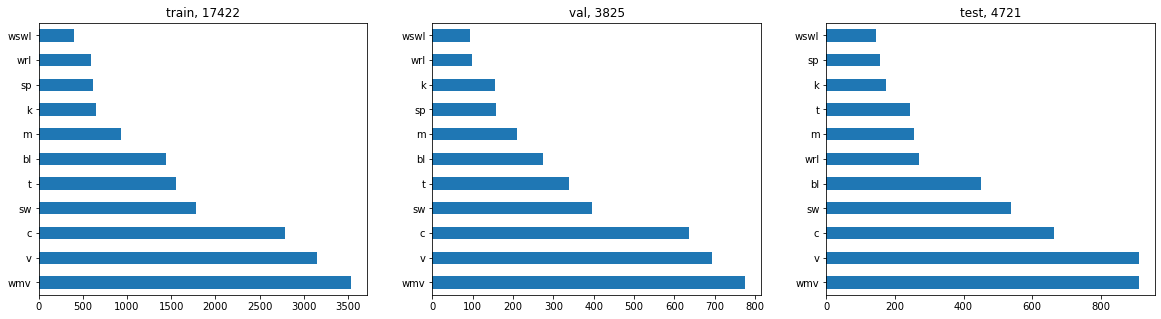

In [5]:
test_plates = train_test_split(df.platename.unique(), random_state=2022, test_size=0.2, shuffle=True)[1].tolist()
testseries = pd.Series(test_plates)
inds = testseries.apply(lambda x: 'wortel' in x)
inds = testseries[inds].sample(11).index.values
wortel_plates = testseries[inds].tolist()
test_plates = testseries[testseries.apply(lambda x: x.split('_')[1] != 'wortel')].tolist() + wortel_plates

df_trainval = df[~df.platename.isin(test_plates)]
df_test = df[df.platename.isin(test_plates)]

topclasses = df['label'].value_counts().head(11).index.tolist()

df = df[df['label'].isin(topclasses)]
df_trainval = df_trainval[df_trainval['label'].isin(topclasses)]
df_test = df_test[df_test['label'].isin(topclasses)]

class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(df['label'].tolist()), 
                                                  y=df['label'].tolist())

class_weights = {np.unique(df['label'])[i]:class_weights[i] for i in range(len(class_weights))}
df['weights'] = df['label'].map(class_weights)

df_train, df_val = train_test_split(df_trainval, test_size=0.18, random_state=42, shuffle=True)


plt.figure(figsize=(20,5))
plt.subplot(1,3,1);df_train.txt_label.value_counts().plot(kind='barh');plt.title(f'train, {df_train.shape[0]}')
plt.subplot(1,3,2);df_val.txt_label.value_counts().plot(kind='barh');plt.title(f'val, {df_val.shape[0]}')
plt.subplot(1,3,3);df_test.txt_label.value_counts().plot(kind='barh');plt.title(f'test, {df_test.shape[0]}');

In [6]:
assert len(set(df_train.filename.tolist()).intersection(df_test.filename.tolist())) == 0
assert len(set(df_train.filename.tolist()).intersection(df_val.filename.tolist())) == 0

In [7]:
df_train.to_parquet(f"{SAVE_DIR}/df_train_{setting}.parquet")
df_val.to_parquet(f"{SAVE_DIR}/df_val_{setting}.parquet")
df_test.to_parquet(f"{SAVE_DIR}/df_test_{setting}.parquet")

In [8]:
df_train.label.value_counts()

9     3535
8     3154
7     2785
4     1777
3     1558
0     1440
6      928
5      646
2      610
10     590
1      399
Name: label, dtype: int64

# Creating Pytorch Datasets and Dataloaders

In [9]:
transforms_list_train = [
#     A.SmallestMaxSize(max_size=150),
#     A.Resize(height=150,width=150,p=1),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225], p=1, always_apply=True),
    A.ShiftScaleRotate(shift_limit=0.01,rotate_limit=45, scale_limit=0, p=.5),
    A.Rotate(limit=90, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.RandomGamma(p=0.5),
     A.RandomBrightnessContrast(p=0.2),
     A.GaussianBlur(blur_limit=(3,3), p=0.1)
]

transforms_list_test = [
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225], 
                p=1, 
                always_apply=True)
]

train_dataset = InsectImgDataset(df=df_train.reset_index(drop=True), transform=A.Compose(transforms_list_train))
valid_dataset = InsectImgDataset(df=df_val.reset_index(drop=True), transform=A.Compose(transforms_list_test))
test_dataset = InsectImgDataset(df=df_test.reset_index(drop=True), transform=A.Compose(transforms_list_test))

batch_size = 32
batch_size_val = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=worker_init_fn)

# plt.imshow(train_dataset[0][0]); plt.title(f"Example train image, class:{train_dataset[0][1]}");

#### Defining the model and training parameters

In [10]:
torch.backends.cudnn.benchmark = True

In [11]:
modelname = "vgg16"
model = model_selector(modelname, pretrained=True)

if modelname.startswith("dense"):
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("resn"):
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("efficient"):
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs,len(topclasses))
if modelname.startswith("vgg"):
    num_ftrs = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_ftrs, len(topclasses))
    
# Choosing whether to train on a gpu
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')# Number of gpus
model = model.to('cuda', dtype=torch.float)

num_epochs = 40

class_sample_count = np.unique(df_train.label, return_counts=True)[1]
weight = 1. / class_sample_count  
criterion = nn.CrossEntropyLoss(label_smoothing=.25, weight=torch.Tensor(weight).cuda())

Train on gpu: True


In [12]:
optimizer = optim.Adam(model.parameters(), lr=.001)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular2")

In [13]:
#optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-3, amsgrad=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, cycle_momentum=False, mode="triangular2")

# Training

In [14]:
results = {"loss":[], "val_loss":[], "train_accuracy":[], "valid_accuracy":[]}
best_valacc = 0
# Model training
for epoch in range(num_epochs):
    # Going through the training set
    correct_train = 0
    model.train()
    for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(train_dataloader, desc='Training..\t'):        
        y_batch = torch.as_tensor(y_batch)
        x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
        for param in model.parameters():
            param.grad = None
        pred = model(x_batch)

        y_batch = y_batch.type(torch.LongTensor).cuda()
        correct_train += (pred.argmax(axis=1) == y_batch).float().sum().item()
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
    train_accuracy = correct_train / len(train_dataset) * 100.
    torch.cuda.empty_cache()

    
    # Going through the validation set
    correct_valid = 0
    model.eval()
    with torch.no_grad():
        for x_batch,y_batch,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(valid_dataloader, desc='Validating..\t'):
            y_batch = torch.as_tensor(y_batch)
            x_batch,y_batch = x_batch.float().cuda(), y_batch.cuda()
            pred = model(x_batch)

            y_batch = y_batch.type(torch.LongTensor).cuda()
            correct_valid += (pred.argmax(axis=1) == y_batch).float().sum().item()
            val_loss = criterion(pred, y_batch)
    valid_accuracy = correct_valid / len(valid_dataset) * 100.

    scheduler.step()


    # Printing results
    print(f"Epoch {epoch}: train_acc: {train_accuracy:.1f}% loss: {loss:.7f},  val_loss: {val_loss:.7f} val_acc: {valid_accuracy:.1f}%")
        
    is_best = valid_accuracy > best_valacc
    if is_best:
        print(f"Validation accuracy improved from {best_valacc:.2f} to {valid_accuracy:.2f}. Saving model..")
    best_valacc = max(valid_accuracy, best_valacc)
    save_checkpoint({
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'best_valacc': best_valacc,
        'loss': results['loss'].append(loss.detach().cpu()),
        'val_loss': results['val_loss'].append(val_loss.detach().cpu()),
        'train_accuracy': results['train_accuracy'].append(train_accuracy),
        'valid_accuracy': results['valid_accuracy'].append(valid_accuracy),
        'optimizer' : optimizer.state_dict(),
    }, is_best, f"{modelname}_{setting}")


Validating..	: 100%|██████████████████| 120/120 [00:11<00:00, 10.50it/s]


Epoch 0: train_acc: 51.2% loss: 2.4117994,  val_loss: 2.6146784 val_acc: 63.7%
Validation accuracy improved from 0.00 to 63.66. Saving model..


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.62it/s]


Epoch 1: train_acc: 66.9% loss: 1.9109842,  val_loss: 2.1956840 val_acc: 73.9%
Validation accuracy improved from 63.66 to 73.93. Saving model..


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.58it/s]


Epoch 2: train_acc: 71.0% loss: 1.3972597,  val_loss: 2.5510364 val_acc: 69.1%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.56it/s]


Epoch 3: train_acc: 73.7% loss: 1.8434454,  val_loss: 2.2948723 val_acc: 78.4%
Validation accuracy improved from 73.93 to 78.43. Saving model..


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.63it/s]


Epoch 4: train_acc: 75.1% loss: 1.4498599,  val_loss: 2.3379376 val_acc: 79.9%
Validation accuracy improved from 78.43 to 79.92. Saving model..


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.61it/s]


Epoch 5: train_acc: 76.7% loss: 2.2676976,  val_loss: 2.4537988 val_acc: 77.8%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.66it/s]


Epoch 6: train_acc: 76.9% loss: 1.6290557,  val_loss: 2.2458584 val_acc: 80.2%
Validation accuracy improved from 79.92 to 80.16. Saving model..


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.60it/s]


Epoch 7: train_acc: 78.0% loss: 2.3196015,  val_loss: 2.6927793 val_acc: 80.2%
Validation accuracy improved from 80.16 to 80.21. Saving model..


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.28it/s]


Epoch 8: train_acc: 78.6% loss: 1.1360536,  val_loss: 2.4149570 val_acc: 79.2%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.39it/s]


Epoch 9: train_acc: 79.0% loss: 1.8820915,  val_loss: 2.2355061 val_acc: 78.1%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.34it/s]


Epoch 10: train_acc: 79.4% loss: 1.7479498,  val_loss: 2.4758096 val_acc: 80.5%
Validation accuracy improved from 80.21 to 80.52. Saving model..


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.51it/s]


Epoch 11: train_acc: 79.7% loss: 1.7433438,  val_loss: 2.3659184 val_acc: 82.2%
Validation accuracy improved from 80.52 to 82.22. Saving model..


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.33it/s]


Epoch 12: train_acc: 80.0% loss: 2.4208744,  val_loss: 2.2214704 val_acc: 82.3%
Validation accuracy improved from 82.22 to 82.30. Saving model..


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.60it/s]


Epoch 13: train_acc: 80.6% loss: 1.9545448,  val_loss: 2.3992510 val_acc: 80.6%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.61it/s]


Epoch 14: train_acc: 80.7% loss: 2.2471209,  val_loss: 2.4336004 val_acc: 82.7%
Validation accuracy improved from 82.30 to 82.69. Saving model..


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.33it/s]


Epoch 15: train_acc: 80.6% loss: 1.4469373,  val_loss: 2.3925102 val_acc: 82.0%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.35it/s]


Epoch 16: train_acc: 80.4% loss: 2.0962808,  val_loss: 2.2889915 val_acc: 81.6%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.39it/s]


Epoch 17: train_acc: 80.6% loss: 2.0345755,  val_loss: 2.1958113 val_acc: 79.7%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.36it/s]


Epoch 18: train_acc: 81.1% loss: 1.7047620,  val_loss: 2.5554290 val_acc: 80.5%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.36it/s]


Epoch 19: train_acc: 80.8% loss: 2.2456641,  val_loss: 2.6307769 val_acc: 80.8%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.28it/s]


Epoch 20: train_acc: 81.0% loss: 1.7343358,  val_loss: 2.3919582 val_acc: 82.5%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.29it/s]


Epoch 21: train_acc: 81.5% loss: 1.6256517,  val_loss: 2.5265813 val_acc: 82.8%
Validation accuracy improved from 82.69 to 82.77. Saving model..


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.30it/s]


Epoch 22: train_acc: 81.4% loss: 2.2203946,  val_loss: 2.4783771 val_acc: 81.4%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.26it/s]


Epoch 23: train_acc: 81.5% loss: 1.9437058,  val_loss: 2.6995120 val_acc: 81.0%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.24it/s]


Epoch 24: train_acc: 80.9% loss: 2.1849120,  val_loss: 2.3260498 val_acc: 82.0%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.34it/s]


Epoch 25: train_acc: 81.6% loss: 1.4995102,  val_loss: 2.3656411 val_acc: 80.0%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.64it/s]


Epoch 26: train_acc: 81.2% loss: 1.9657029,  val_loss: 2.1760323 val_acc: 79.5%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.67it/s]


Epoch 27: train_acc: 81.8% loss: 1.8245485,  val_loss: 2.2829237 val_acc: 80.7%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.64it/s]


Epoch 28: train_acc: 81.4% loss: 1.5184560,  val_loss: 2.2178342 val_acc: 82.4%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.70it/s]


Epoch 29: train_acc: 81.5% loss: 1.3134754,  val_loss: 2.2671680 val_acc: 80.4%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.66it/s]


Epoch 30: train_acc: 81.8% loss: 1.6722682,  val_loss: 2.2513735 val_acc: 81.2%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.33it/s]


Epoch 31: train_acc: 80.9% loss: 2.1942825,  val_loss: 2.1725209 val_acc: 82.6%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.61it/s]


Epoch 32: train_acc: 80.8% loss: 2.0407634,  val_loss: 2.5292349 val_acc: 81.6%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.65it/s]


Epoch 33: train_acc: 80.9% loss: 1.5348508,  val_loss: 2.5480428 val_acc: 80.9%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.57it/s]


Epoch 34: train_acc: 81.4% loss: 1.5764402,  val_loss: 2.2385304 val_acc: 81.2%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.64it/s]


Epoch 35: train_acc: 81.1% loss: 2.4988000,  val_loss: 2.4120250 val_acc: 81.0%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.65it/s]


Epoch 36: train_acc: 81.6% loss: 1.5668643,  val_loss: 2.1337371 val_acc: 82.3%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.67it/s]


Epoch 37: train_acc: 81.5% loss: 2.3438537,  val_loss: 2.0160556 val_acc: 81.6%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.64it/s]


Epoch 38: train_acc: 81.2% loss: 2.2180567,  val_loss: 2.4307833 val_acc: 81.8%


Validating..	: 100%|██████████████████| 120/120 [00:06<00:00, 17.66it/s]


Epoch 39: train_acc: 81.4% loss: 1.6638585,  val_loss: 2.5816531 val_acc: 82.1%
